In [1]:
# To Stop GPUs working

In [2]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

# Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import PIL # pillow - image processing
import tensorflow as tf
from PIL import Image
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import matplotlib
import matplotlib.pyplot as plt
from keras.optimizers import Adam

tf.random.set_seed(123)

Using TensorFlow backend.


In [4]:
import os,datetime
#os.chdir(r"D:\PhD Classes (Big_files)\Neural Networks\Neural Networks\Project\2nd_dataset_image\Cropped_1Channel_Mask")
#os.chdir(r'/home/said.mejia/Projects/Deep_Learning/Dataset')
print(os.path.dirname(os.getcwd()))

C:\Users\said_\Google Drive\THE CITY COLLEGE OF NEW YORK\Ph.D.Classes\Spring21\Neural Networks\Project\Repo_CCNY_4\final-project-landandbuildingsatimg-ccny\notebooks


In [5]:
import sys
sys.path
sys.path.append(r'../../src/')

In [6]:
from visualization import visualize

In [ ]:
from models.keras_segmentation.models.segnet import resnet50_segnet
from models.keras_segmentation.models.segnet import vgg_segnet
from models.keras_segmentation.models.unet import resnet50_unet
from models.keras_segmentation.models.unet import vgg_unet

# Select the folder that you are working on

In [8]:
folder_dataset = 'Balanced_80'

# PLEASE READ LINE BELLOW

### Before use this notebook, please create a folder in githubfolder/models/Save_Models or run the following commented line

In [9]:
folder_name = 'Save_Balanced_80_SM_JP'
#os.mkdir(r'../../models/'f'{folder_name}')

# Reading Images and Masks

In [10]:
reading_images = sorted(glob.glob(r'../../data/processed/'f'{folder_dataset}''/test/Images/*.png'))
reading_masks = sorted(glob.glob(r'../../data/processed/'f'{folder_dataset}''/test/Masks/*.png'))
# reading_weights = (glob.glob(r'../../data/processed/Cropped_same_name/train/Sample_Weights/*.npy'))
img_num = 9

In [11]:
img = PIL.Image.open(reading_images[img_num], 'r')
mask = PIL.Image.open(reading_masks[img_num], 'r')

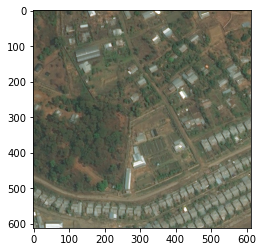

In [12]:
plt.imshow(np.asarray(img))

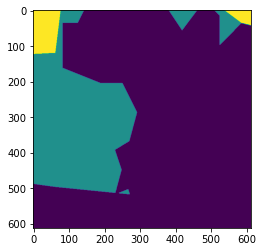

In [13]:
plt.imshow(np.asarray(mask))

# GPU

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


# History Function

In [15]:
def plot_history(history):
       
    acc = history.history['iou_score']
    val_acc = history.history['val_iou_score']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

## Ploting the class labels

In [16]:
labels = pd.read_csv('../../data/processed/'f'{folder_dataset}''/class_dict.csv')
classes = list(labels['name'])
classes

['unknown',
 'urban_land',
 'agriculture_land',
 'rangeland',
 'forest_land',
 'water',
 'barren_land']

In [17]:
labels = classes
col_dict = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green', 
           4: 'yellow', 5: 'purple', 6: 'grey', }
col_dict

{0: 'blue',
 1: 'red',
 2: 'orange',
 3: 'green',
 4: 'yellow',
 5: 'purple',
 6: 'grey'}

# Paths

In [ ]:
model_balanced_name = ['resnet50_segnet','vgg_segnet','vgg_unet','resnet50_unet']

# ResNet_Segnet

In [19]:
i = 0

In [20]:
callbacks = [
    ModelCheckpoint(monitor='val_iou_score',
                filepath= '../../models/'f'{folder_name}''/' + 'Model_Best_Weights_'f'{model_balanced_name[i]}''.hdf5',
                        save_best_only=True,
                        verbose=1, mode = 'max'), 
    EarlyStopping(monitor='val_iou_score',patience=5,
                           restore_best_weights=True,
                           mode='max'),
    ReduceLROnPlateau(monitor='val_iou_score', factor=0.5,
                              patience=3, min_lr=0.000001),
   # tf.keras.callbacks.TensorBoard(log_dir='./logs', profile_batch=5)
]

In [21]:
model = resnet50_segnet(n_classes=7 , input_height=512, input_width=512)

In [22]:
from datetime import datetime
start = datetime.now()
total_loss, optim, metrics,  train_gen,  steps_per_epoch, val_gen, val_steps_per_epoch, epochs, callbacks, gen_use_multiprocessing, initial_epoch = model.train(
    input_height = 612,
    input_width = 612,
    learn_rate=0.00001,
    verify_dataset = False,
    train_images =  '../../data/processed/'f'{folder_dataset}''/train/Images/',
    train_annotations = '../../data/processed/'f'{folder_dataset}''/train/Masks/',
    validate= True,
    val_images =  '../../data/processed/'f'{folder_dataset}''/val/Images/',
    val_annotations = '../../data/processed/'f'{folder_dataset}''/val/Masks/',
    epochs=100, 
    callbacks = callbacks,
#     other_inputs_paths = ['../../data/processed/'f'{folder_dataset}''/Sample_Weights/']
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))


Time Taken for testing: 0:00:00.002864


In [23]:
optima = Adam(lr=0.00001)
model.compile(loss=total_loss, optimizer= optima, metrics= metrics)

In [ ]:
nn_model = model.fit(train_gen,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=val_gen,
                  validation_steps=val_steps_per_epoch,
                  epochs=epochs, callbacks=callbacks,
                  use_multiprocessing=gen_use_multiprocessing, initial_epoch=initial_epoch) #, sample_weight = sample_weight)

Epoch 1/100
512/512 [==============================] - 244s 476ms/step - loss: 0.6412 - iou_score: 0.3139 - f1-score: 0.4573 - val_loss: 0.3604 - val_iou_score: 0.5427 - val_f1-score: 0.6845

Epoch 00001: val_iou_score improved from -inf to 0.54267, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_Weights_resnet50_segnet.hdf5
Epoch 2/100
512/512 [==============================] - 231s 451ms/step - loss: 0.5474 - iou_score: 0.4010 - f1-score: 0.5554 - val_loss: 0.5955 - val_iou_score: 0.5538 - val_f1-score: 0.6928

Epoch 00002: val_iou_score improved from 0.54267 to 0.55377, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_Weights_resnet50_segnet.hdf5
Epoch 3/100
512/512 [==============================] - 226s 442ms/step - loss: 0.5219 - iou_score: 0.4265 - f1-score: 0.5801 - val_loss: 0.2943 - val_iou_score: 0.5716 - val_f1-score: 0.7098

Epoch 00003: val_iou_score improved from 0.55377 to 0.57163, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Be

## Saving the model

In [ ]:
model.save('../../models/'f'{folder_name}''/' + 'Model_Save_Model_'f'{model_balanced_name[i]}''.h5')

In [ ]:
plot_history(nn_model)

In [ ]:
out = model.predict_segmentation(
    inp= reading_images[img_num],
    out_fname= '../../models/'f'{folder_name}''/' + 'Model_'f'{model_balanced_name[i]}''.png'
)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

axes[0].imshow(np.asarray(img))
axes[1] = visualize.plot_label(np.asarray(mask), labels,col_dict, axes[1], fig, colorbar = False)
axes[2] = visualize.plot_label(np.asarray(out), labels,col_dict, axes[2], fig, colorbar = True)
plt.savefig('../../models/'f'{folder_name}''/' + 'Model_Comparison_'f'{model_balanced_name[i]}''.png')

# VGG_Segnet

In [19]:
i = 1

In [20]:
callbacks = [
    ModelCheckpoint(monitor='val_iou_score',
                filepath= '../../models/'f'{folder_name}''/' + 'Model_Best_Weights_'f'{model_balanced_name[i]}''.hdf5',
                        save_best_only=True,
                        verbose=1, mode = 'max'), 
    EarlyStopping(monitor='val_iou_score',patience=5,
                           restore_best_weights=True,
                           mode='max'),
    ReduceLROnPlateau(monitor='val_iou_score', factor=0.5,
                              patience=3, min_lr=0.000001),
   # tf.keras.callbacks.TensorBoard(log_dir='./logs', profile_batch=5)
]

In [21]:
model = vgg_segnet(n_classes=7 , input_height=512, input_width=512)

In [22]:
from datetime import datetime
start = datetime.now()
total_loss, optim, metrics,  train_gen,  steps_per_epoch, val_gen, val_steps_per_epoch, epochs, callbacks, gen_use_multiprocessing, initial_epoch = model.train(
    input_height = 612,
    input_width = 612,
    learn_rate=0.00001,
    verify_dataset = False,
    train_images =  '../../data/processed/'f'{folder_dataset}''/train/Images/',
    train_annotations = '../../data/processed/'f'{folder_dataset}''/train/Masks/',
    validate= True,
    val_images =  '../../data/processed/'f'{folder_dataset}''/val/Images/',
    val_annotations = '../../data/processed/'f'{folder_dataset}''/val/Masks/',
    epochs=100, 
    callbacks = callbacks,
#     other_inputs_paths = ['../../data/processed/'f'{folder_dataset}''/Sample_Weights/']
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))


Time Taken for testing: 0:00:00.002864


In [23]:
optima = Adam(lr=0.00001)
model.compile(loss=total_loss, optimizer= optima, metrics= metrics)

In [ ]:
nn_model = model.fit(train_gen,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=val_gen,
                  validation_steps=val_steps_per_epoch,
                  epochs=epochs, callbacks=callbacks,
                  use_multiprocessing=gen_use_multiprocessing, initial_epoch=initial_epoch) #, sample_weight = sample_weight)

Epoch 1/100
512/512 [==============================] - 244s 476ms/step - loss: 0.6412 - iou_score: 0.3139 - f1-score: 0.4573 - val_loss: 0.3604 - val_iou_score: 0.5427 - val_f1-score: 0.6845

Epoch 00001: val_iou_score improved from -inf to 0.54267, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_Weights_resnet50_segnet.hdf5
Epoch 2/100
488/512 [===========================>..] - ETA: 8s - loss: 0.5444 - iou_score: 0.4036 - f1-score: 0.5580

## Saving the model

In [ ]:
model.save('../../models/'f'{folder_name}''/' + 'Model_Save_Model_'f'{model_balanced_name[i]}''.h5')

In [ ]:
plot_history(nn_model)

In [ ]:
out = model.predict_segmentation(
    inp= reading_images[img_num],
    out_fname= '../../models/'f'{folder_name}''/' + 'Model_'f'{model_balanced_name[i]}''.png'
)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

axes[0].imshow(np.asarray(img))
axes[1] = visualize.plot_label(np.asarray(mask), labels,col_dict, axes[1], fig, colorbar = False)
axes[2] = visualize.plot_label(np.asarray(out), labels,col_dict, axes[2], fig, colorbar = True)
plt.savefig('../../models/'f'{folder_name}''/' + 'Model_Comparison_'f'{model_balanced_name[i]}''.png')

# VGG_Unet

In [19]:
i = 2

In [20]:
callbacks = [
    ModelCheckpoint(monitor='val_iou_score',
                filepath= '../../models/'f'{folder_name}''/' + 'Model_Best_Weights_'f'{model_balanced_name[i]}''.hdf5',
                        save_best_only=True,
                        verbose=1, mode = 'max'), 
    EarlyStopping(monitor='val_iou_score',patience=5,
                           restore_best_weights=True,
                           mode='max'),
    ReduceLROnPlateau(monitor='val_iou_score', factor=0.5,
                              patience=3, min_lr=0.000001),
   # tf.keras.callbacks.TensorBoard(log_dir='./logs', profile_batch=5)
]

In [21]:
model = vgg_unet(n_classes=7 , input_height=512, input_width=512)

In [22]:
from datetime import datetime
start = datetime.now()
total_loss, optim, metrics,  train_gen,  steps_per_epoch, val_gen, val_steps_per_epoch, epochs, callbacks, gen_use_multiprocessing, initial_epoch = model.train(
    input_height = 612,
    input_width = 612,
    learn_rate=0.00001,
    verify_dataset = False,
    train_images =  '../../data/processed/'f'{folder_dataset}''/train/Images/',
    train_annotations = '../../data/processed/'f'{folder_dataset}''/train/Masks/',
    validate= True,
    val_images =  '../../data/processed/'f'{folder_dataset}''/val/Images/',
    val_annotations = '../../data/processed/'f'{folder_dataset}''/val/Masks/',
    epochs=100, 
    callbacks = callbacks,
#     other_inputs_paths = ['../../data/processed/'f'{folder_dataset}''/Sample_Weights/']
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))


Time Taken for testing: 0:00:00.002864


In [23]:
optima = Adam(lr=0.00001)
model.compile(loss=total_loss, optimizer= optima, metrics= metrics)

In [ ]:
nn_model = model.fit(train_gen,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=val_gen,
                  validation_steps=val_steps_per_epoch,
                  epochs=epochs, callbacks=callbacks,
                  use_multiprocessing=gen_use_multiprocessing, initial_epoch=initial_epoch) #, sample_weight = sample_weight)

Epoch 1/100
512/512 [==============================] - 244s 476ms/step - loss: 0.6412 - iou_score: 0.3139 - f1-score: 0.4573 - val_loss: 0.3604 - val_iou_score: 0.5427 - val_f1-score: 0.6845

Epoch 00001: val_iou_score improved from -inf to 0.54267, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_Weights_resnet50_segnet.hdf5
Epoch 2/100
488/512 [===========================>..] - ETA: 8s - loss: 0.5444 - iou_score: 0.4036 - f1-score: 0.5580

## Saving the model

In [ ]:
model.save('../../models/'f'{folder_name}''/' + 'Model_Save_Model_'f'{model_balanced_name[i]}''.h5')

In [ ]:
plot_history(nn_model)

In [ ]:
out = model.predict_segmentation(
    inp= reading_images[img_num],
    out_fname= '../../models/'f'{folder_name}''/' + 'Model_'f'{model_balanced_name[i]}''.png'
)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

axes[0].imshow(np.asarray(img))
axes[1] = visualize.plot_label(np.asarray(mask), labels,col_dict, axes[1], fig, colorbar = False)
axes[2] = visualize.plot_label(np.asarray(out), labels,col_dict, axes[2], fig, colorbar = True)
plt.savefig('../../models/'f'{folder_name}''/' + 'Model_Comparison_'f'{model_balanced_name[i]}''.png')

# ResNet_Unet

In [19]:
i = 3

In [20]:
callbacks = [
    ModelCheckpoint(monitor='val_iou_score',
                filepath= '../../models/'f'{folder_name}''/' + 'Model_Best_Weights_'f'{model_balanced_name[i]}''.hdf5',
                        save_best_only=True,
                        verbose=1, mode = 'max'), 
    EarlyStopping(monitor='val_iou_score',patience=5,
                           restore_best_weights=True,
                           mode='max'),
    ReduceLROnPlateau(monitor='val_iou_score', factor=0.5,
                              patience=3, min_lr=0.000001),
   # tf.keras.callbacks.TensorBoard(log_dir='./logs', profile_batch=5)
]

In [21]:
model = resnet50_unet(n_classes=7 , input_height=512, input_width=512)

In [22]:
from datetime import datetime
start = datetime.now()
total_loss, optim, metrics,  train_gen,  steps_per_epoch, val_gen, val_steps_per_epoch, epochs, callbacks, gen_use_multiprocessing, initial_epoch = model.train(
    input_height = 612,
    input_width = 612,
    learn_rate=0.00001,
    verify_dataset = False,
    train_images =  '../../data/processed/'f'{folder_dataset}''/train/Images/',
    train_annotations = '../../data/processed/'f'{folder_dataset}''/train/Masks/',
    validate= True,
    val_images =  '../../data/processed/'f'{folder_dataset}''/val/Images/',
    val_annotations = '../../data/processed/'f'{folder_dataset}''/val/Masks/',
    epochs=100, 
    callbacks = callbacks,
#     other_inputs_paths = ['../../data/processed/'f'{folder_dataset}''/Sample_Weights/']
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))


Time Taken for testing: 0:00:00.002864


In [23]:
optima = Adam(lr=0.00001)
model.compile(loss=total_loss, optimizer= optima, metrics= metrics)

In [ ]:
nn_model = model.fit(train_gen,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=val_gen,
                  validation_steps=val_steps_per_epoch,
                  epochs=epochs, callbacks=callbacks,
                  use_multiprocessing=gen_use_multiprocessing, initial_epoch=initial_epoch) #, sample_weight = sample_weight)

Epoch 1/100
512/512 [==============================] - 244s 476ms/step - loss: 0.6412 - iou_score: 0.3139 - f1-score: 0.4573 - val_loss: 0.3604 - val_iou_score: 0.5427 - val_f1-score: 0.6845

Epoch 00001: val_iou_score improved from -inf to 0.54267, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_Weights_resnet50_segnet.hdf5
Epoch 2/100
488/512 [===========================>..] - ETA: 8s - loss: 0.5444 - iou_score: 0.4036 - f1-score: 0.5580

## Saving the model

In [ ]:
model.save('../../models/'f'{folder_name}''/' + 'Model_Save_Model_'f'{model_balanced_name[i]}''.h5')

In [ ]:
plot_history(nn_model)

In [ ]:
out = model.predict_segmentation(
    inp= reading_images[img_num],
    out_fname= '../../models/'f'{folder_name}''/' + 'Model_'f'{model_balanced_name[i]}''.png'
)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

axes[0].imshow(np.asarray(img))
axes[1] = visualize.plot_label(np.asarray(mask), labels,col_dict, axes[1], fig, colorbar = False)
axes[2] = visualize.plot_label(np.asarray(out), labels,col_dict, axes[2], fig, colorbar = True)
plt.savefig('../../models/'f'{folder_name}''/' + 'Model_Comparison_'f'{model_balanced_name[i]}''.png')